# 🎯 Module 5 – Integrated Modeling, Evaluation & Capstone Mini‑Project

**Welcome to the capstone!** This notebook demonstrates how to build a complete, production-ready machine learning pipeline that avoids common pitfalls like data leakage and overly optimistic performance estimates.

## 🚀 What You'll Build
- **End-to-end ML pipeline**: From raw data to model deployment
- **Robust model comparison**: Using nested cross-validation 
- **Professional evaluation**: Multiple metrics with proper interpretation
- **Reproducible workflow**: Code that others can trust and extend

## 🎓 Real-World Context
This workflow mirrors what data scientists do in industry: systematically compare models, validate performance claims, and deliver reliable predictions. By the end, you'll have a complete framework you can adapt to any regression problem.

## 1 | Learning Objectives
By the end of this module you will be able to:

1. **Assemble** a leakage‑free ML pipeline (preprocessing → model → evaluation).
2. **Select** and justify regression metrics (RMSE, MAE, R²) for different goals.
3. **Apply** robust validation (nested CV) to compare Ridge, Lasso & LightGBM fairly.
4. **Tune** hyper‑parameters efficiently (Grid/Random/Bayesian optional).
5. **Communicate** findings in a concise, reproducible report.

## 🧠 Key Concepts & Intuitive Analogies

Understanding these concepts is crucial for building reliable ML systems:

| Concept | What It Does | Why It Matters | Analogy |
|---------|-------------|----------------|---------|
| **🔄 Pipeline** | Chains preprocessing + model so each CV fold sees identical transformations | Prevents data leakage and ensures reproducibility | **Assembly line**: Every car (CV fold) goes through exactly the same stations in the same order |
| **🎯 Nested CV** | Inner loop optimizes hyperparameters; outer loop estimates true performance | Gives unbiased performance estimates | **Cooking competition**: Inner judges taste-test recipes (hyperparameter tuning), outer judges evaluate final dishes blindfolded (performance estimation) |
| **📊 Metric Choice** | Different metrics emphasize different aspects of prediction quality | Choose based on business goals and error tolerance | **Grading systems**: RMSE = harsh professor (penalizes big mistakes heavily), MAE = lenient teacher (treats all errors equally), R² = percentage score |
| **📏 Baseline Model** | Simple predictor (e.g., mean) to benchmark against | Ensures complex models actually add value | **Speed limit**: Minimum performance bar - if your sports car can't beat a bicycle, something's wrong! |
| **🔬 Reproducibility** | Fixed random seeds + saved configurations + version control | Others can verify and build upon your work | **Scientific recipe**: Exact ingredients, measurements, and steps so anyone can recreate the results |

💡 **Pro Tip**: These aren't just academic concepts - they're the difference between models that work in production vs. those that fail spectacularly!

In [2]:
# 📦 SETUP: Imports & Configuration
"""
Professional ML workflow requires careful setup.
We import only what we need and configure for reproducibility.
"""

# Core data science stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import sklearn

# ML pipeline components
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Models we'll compare
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Utilities for saving/loading
import json
import joblib

# 🎨 Visualization settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 110
plt.style.use('seaborn-v0_8')

# 🎲 Reproducibility settings
np.random.seed(42)  # Answer to the Ultimate Question
warnings.filterwarnings('ignore', category=UserWarning)

print("✅ All packages imported successfully!")
print(f"📊 Using pandas {pd.__version__}, scikit-learn {sklearn.__version__}")

✅ All packages imported successfully!
📊 Using pandas 2.2.3, scikit-learn 1.6.1


In [3]:
# 🏠 DATA LOADING: California Housing Dataset
"""
We'll predict house prices using the famous California housing dataset.
This represents a realistic regression problem with mixed data types.
"""

# Load the dataset
print("🔄 Loading California Housing dataset...")
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

print(f"📊 Dataset shape: {X.shape[0]:,} houses × {X.shape[1]} features")
print(f"🎯 Target: House price (median, in $100k units)")
print(f"📍 Geographic scope: California districts from 1990 census")

# 🎯 STRATEGIC DATA SPLITTING
"""
Why this 3-way split?
- Test set (20%): Final evaluation - NEVER touched during development
- Train set (60%): Model training  
- Validation set (20%): Hyperparameter tuning

This prevents overfitting and gives honest performance estimates.
"""

print("\n🔄 Creating strategic data splits...")

# First split: separate test set (hold-out for final evaluation)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

# Second split: separate training and validation from remaining data
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42  # 0.25 of 0.8 = 0.2 overall
)

# 📊 Visualize the split
split_info = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test', 'Total'],
    'Size': [len(X_train), len(X_val), len(X_test), len(X)],
    'Percentage': [len(X_train)/len(X)*100, len(X_val)/len(X)*100, len(X_test)/len(X)*100, 100]
})

print("\n📊 Data Split Summary:")
print(split_info.round(1))

# Quick sanity check
assert len(X_train) + len(X_val) + len(X_test) == len(X), "Split sizes don't add up!"
print(f"\n✅ Splits verified: {len(X_train):,} + {len(X_val):,} + {len(X_test):,} = {len(X):,}")

# Show target distribution across splits
print(f"\n🎯 Target distribution check:")
print(f"   Train mean: ${y_train.mean():.1f}00k, std: ${y_train.std():.1f}00k")
print(f"   Val mean:   ${y_val.mean():.1f}00k, std: ${y_val.std():.1f}00k") 
print(f"   Test mean:  ${y_test.mean():.1f}00k, std: ${y_test.std():.1f}00k")

🔄 Loading California Housing dataset...
📊 Dataset shape: 20,640 houses × 8 features
🎯 Target: House price (median, in $100k units)
📍 Geographic scope: California districts from 1990 census

🔄 Creating strategic data splits...

📊 Data Split Summary:
      Dataset   Size  Percentage
0    Training  12384        60.0
1  Validation   4128        20.0
2        Test   4128        20.0
3       Total  20640       100.0

✅ Splits verified: 12,384 + 4,128 + 4,128 = 20,640

🎯 Target distribution check:
   Train mean: $2.100k, std: $1.200k
   Val mean:   $2.100k, std: $1.200k
   Test mean:  $2.100k, std: $1.100k


### 3 | Exploratory Data Analysis

🔍 DATASET OVERVIEW
📊 Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
🎯 Target: House prices ranging $0.100k to $5.000k

📋 Sample Data:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target_price
17244,2.3681,39.0,3.922460,1.018717,1404.0,3.754011,34.43,-119.67,2.41400
8817,10.1357,24.0,7.564516,0.985112,2248.0,2.789082,33.74,-118.32,5.00001
19686,1.6719,41.0,3.908012,0.916914,856.0,2.540059,39.13,-121.62,0.64100
3545,4.8333,9.0,5.201093,1.009836,1884.0,2.059016,34.24,-118.63,2.77200
17019,5.5902,38.0,7.010127,0.979747,994.0,2.516456,37.52,-122.30,4.17000



📈 Statistical Summary:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,12384.00,12384.00,12384.00,12384.00,12384.00,12384.00,12384.00,12384.00
mean,3.87,28.59,5.41,1.09,1427.29,3.03,35.64,-119.58
std,1.89,12.61,2.08,0.36,1140.98,7.07,2.13,2.01
min,0.50,1.00,0.89,0.38,3.00,0.69,32.56,-124.35
25%,2.56,18.00,4.44,1.01,790.00,2.43,33.93,-121.80
50%,3.55,29.00,5.22,1.05,1170.00,2.82,34.26,-118.50
75%,4.74,37.00,6.05,1.10,1726.00,3.28,37.72,-118.01
max,15.00,52.00,61.81,11.41,35682.00,599.71,41.95,-114.31



🔍 DATA QUALITY ASSESSMENT
❓ Missing values: 0 total
✅ No missing values found!

📋 Data Types:
float64    8
Name: count, dtype: int64

📊 VISUAL DATA EXPLORATION


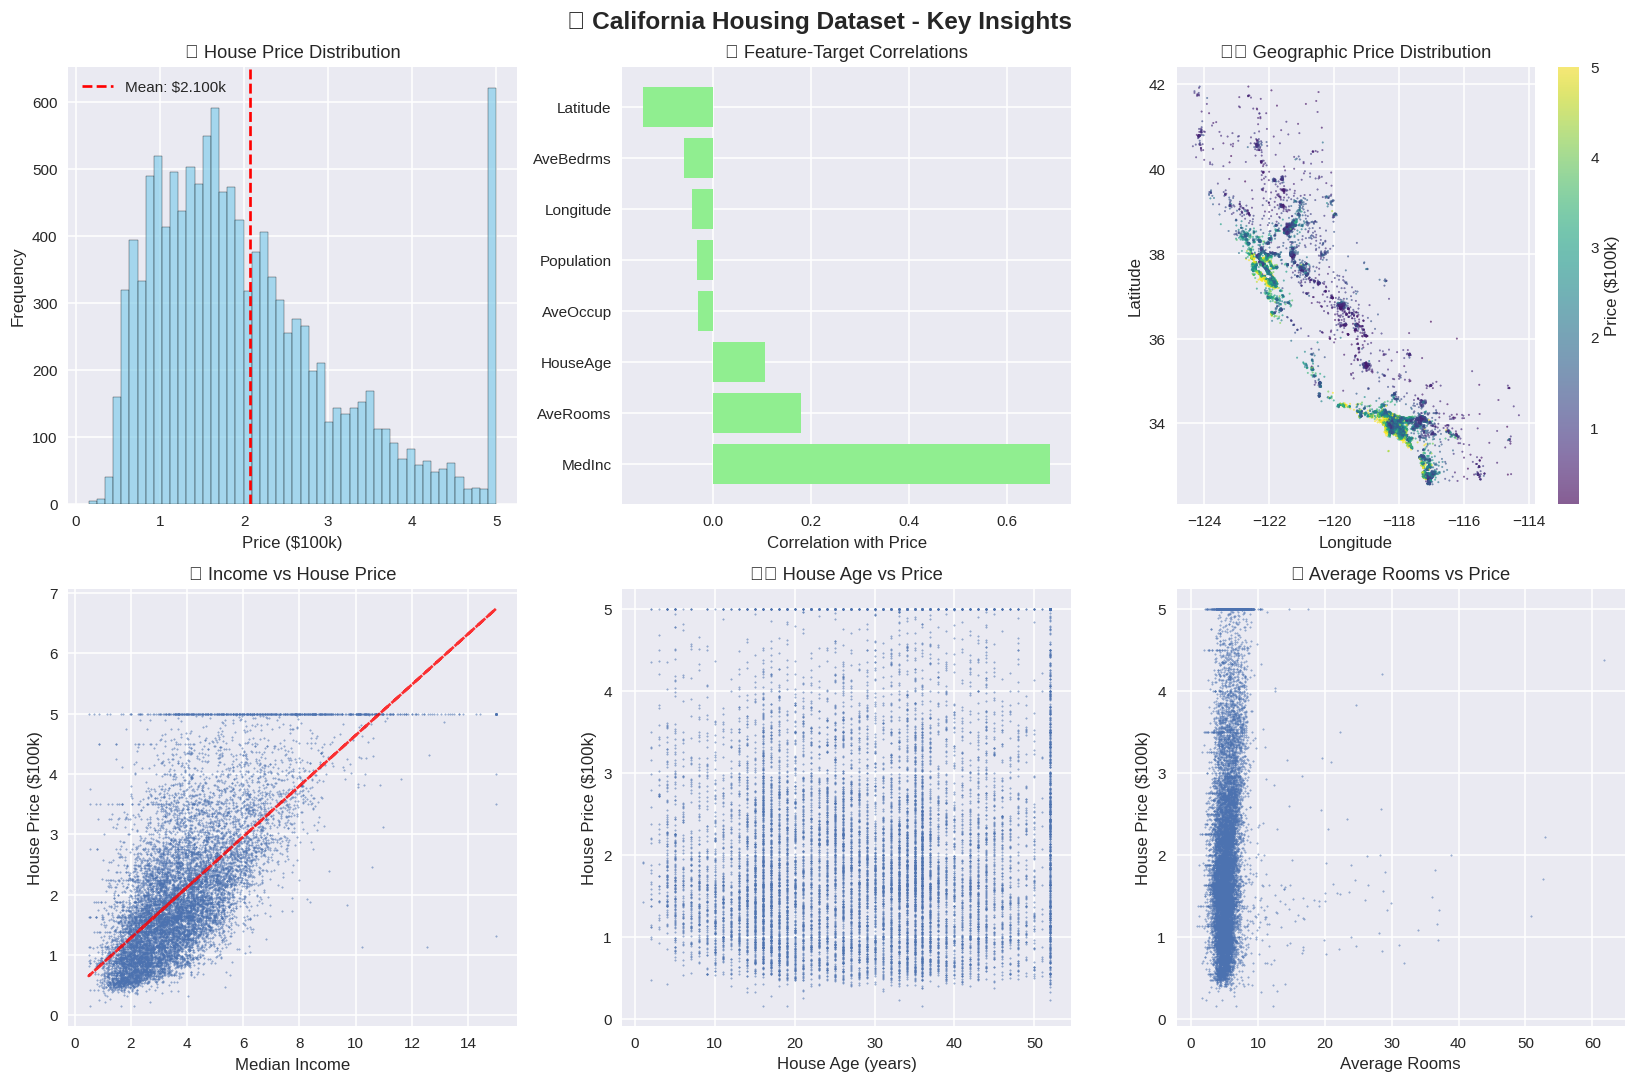


💡 KEY INSIGHTS FROM EDA
🎯 Price range: $0.100k - $5.000k (mean: $2.100k)
🔗 Strongest correlation: MedInc (0.689)
🔗 Weakest correlation: Latitude (-0.144)
📊 All features are numeric - no categorical encoding needed
✅ No missing values - no imputation required
⚖️ Features have different scales - StandardScaler recommended


In [4]:
# 🔍 EXPLORATORY DATA ANALYSIS
"""
Before building models, we need to understand our data.
This guides preprocessing decisions and model selection.
"""

print("🔍 DATASET OVERVIEW")
print("=" * 50)

# Basic info about the dataset
print(f"📊 Features: {list(X_train.columns)}")
print(f"🎯 Target: House prices ranging ${y_train.min():.1f}00k to ${y_train.max():.1f}00k")

# Show first few rows with target
sample_data = X_train.head().copy()
sample_data['target_price'] = y_train.head()
print(f"\n📋 Sample Data:")
display(sample_data)

# Statistical summary
print(f"\n📈 Statistical Summary:")
stats_summary = X_train.describe().round(2)
display(stats_summary)

# 🔍 DATA QUALITY CHECK
print("\n🔍 DATA QUALITY ASSESSMENT")
print("=" * 50)

# Check for missing values
missing_data = X_train.isnull().sum()
print(f"❓ Missing values: {missing_data.sum()} total")
if missing_data.sum() > 0:
    print(missing_data[missing_data > 0])
else:
    print("✅ No missing values found!")

# Check data types
print(f"\n📋 Data Types:")
dtype_summary = X_train.dtypes.value_counts()
print(dtype_summary)

# 📊 VISUAL EXPLORATION
print("\n📊 VISUAL DATA EXPLORATION")
print("=" * 50)

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('🏠 California Housing Dataset - Key Insights', fontsize=16, fontweight='bold')

# 1. Target distribution
axes[0,0].hist(y_train, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('🎯 House Price Distribution')
axes[0,0].set_xlabel('Price ($100k)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: ${y_train.mean():.1f}00k')
axes[0,0].legend()

# 2. Feature correlation with target
correlations = X_train.corrwith(y_train).sort_values(ascending=False)
axes[0,1].barh(range(len(correlations)), correlations.values, color='lightgreen')
axes[0,1].set_yticks(range(len(correlations)))
axes[0,1].set_yticklabels(correlations.index)
axes[0,1].set_title('🔗 Feature-Target Correlations')
axes[0,1].set_xlabel('Correlation with Price')

# 3. Geographic distribution (if longitude/latitude available)
if 'Longitude' in X_train.columns and 'Latitude' in X_train.columns:
    scatter = axes[0,2].scatter(X_train['Longitude'], X_train['Latitude'], 
                               c=y_train, cmap='viridis', alpha=0.6, s=1)
    axes[0,2].set_title('🗺️ Geographic Price Distribution')
    axes[0,2].set_xlabel('Longitude')
    axes[0,2].set_ylabel('Latitude')
    plt.colorbar(scatter, ax=axes[0,2], label='Price ($100k)')
else:
    axes[0,2].text(0.5, 0.5, 'Geographic data\nnot available', 
                   ha='center', va='center', transform=axes[0,2].transAxes)
    axes[0,2].set_title('🗺️ Geographic Distribution')

# 4. Income vs Price relationship
if 'MedInc' in X_train.columns:
    axes[1,0].scatter(X_train['MedInc'], y_train, alpha=0.5, s=1)
    axes[1,0].set_title('💰 Income vs House Price')
    axes[1,0].set_xlabel('Median Income')
    axes[1,0].set_ylabel('House Price ($100k)')
    
    # Add trend line
    z = np.polyfit(X_train['MedInc'], y_train, 1)
    p = np.poly1d(z)
    axes[1,0].plot(X_train['MedInc'], p(X_train['MedInc']), "r--", alpha=0.8)

# 5. Age vs Price
if 'HouseAge' in X_train.columns:
    axes[1,1].scatter(X_train['HouseAge'], y_train, alpha=0.5, s=1)
    axes[1,1].set_title('🏗️ House Age vs Price')
    axes[1,1].set_xlabel('House Age (years)')
    axes[1,1].set_ylabel('House Price ($100k)')

# 6. Rooms vs Price
if 'AveRooms' in X_train.columns:
    axes[1,2].scatter(X_train['AveRooms'], y_train, alpha=0.5, s=1)
    axes[1,2].set_title('🏠 Average Rooms vs Price')
    axes[1,2].set_xlabel('Average Rooms')
    axes[1,2].set_ylabel('House Price ($100k)')

plt.tight_layout()
plt.show()

# 📋 KEY INSIGHTS
print("\n💡 KEY INSIGHTS FROM EDA")
print("=" * 50)
print(f"🎯 Price range: ${y_train.min():.1f}00k - ${y_train.max():.1f}00k (mean: ${y_train.mean():.1f}00k)")
print(f"🔗 Strongest correlation: {correlations.index[0]} ({correlations.iloc[0]:.3f})")
print(f"🔗 Weakest correlation: {correlations.index[-1]} ({correlations.iloc[-1]:.3f})")
print(f"📊 All features are numeric - no categorical encoding needed")
print(f"✅ No missing values - no imputation required")
print(f"⚖️ Features have different scales - StandardScaler recommended")

### 4 | Preprocessing Pipeline

In [5]:
# ⚙️ PREPROCESSING PIPELINE DESIGN
"""
The preprocessing pipeline is the foundation of a reliable ML system.
It ensures consistent transformations and prevents data leakage.
"""

print("⚙️ BUILDING PREPROCESSING PIPELINE")
print("=" * 50)

# 🔍 ANALYZE FEATURE TYPES
print("🔍 Analyzing feature types...")

# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"📊 Numeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"🏷️ Categorical features ({len(categorical_cols)}): {categorical_cols if categorical_cols else 'None'}")

# 🏗️ DESIGN PREPROCESSING STRATEGY
print(f"\n🏗️ PREPROCESSING STRATEGY")
print("=" * 30)

if categorical_cols:
    print("📝 Categorical features found - will use OneHotEncoder")
    print("   • Handles unknown categories gracefully")
    print("   • Creates binary indicators for each category")
else:
    print("✅ No categorical features - encoding not needed")

print("📈 Numeric features found - will use StandardScaler")
print("   • Centers features around mean=0")
print("   • Scales features to std=1") 
print("   • Prevents large-scale features from dominating")

# 🔧 BUILD THE PIPELINE
print(f"\n🔧 CONSTRUCTING COLUMN TRANSFORMER")
print("=" * 40)

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ],
    remainder='passthrough',  # Keep any remaining columns as-is
    n_jobs=-1  # Use all available cores for parallel processing
)

print("✅ Preprocessing pipeline created!")
print(f"   • StandardScaler for {len(numeric_cols)} numeric features")
if categorical_cols:
    print(f"   • OneHotEncoder for {len(categorical_cols)} categorical features")
print("   • Parallel processing enabled")

# 🧪 TEST THE PIPELINE
print(f"\n🧪 TESTING PREPROCESSING PIPELINE")
print("=" * 40)

# Fit and transform a small sample to verify it works
print("🔄 Fitting preprocessor on training data...")
X_sample_transformed = preprocessor.fit_transform(X_train[:100])

print(f"✅ Pipeline test successful!")
print(f"   • Input shape: {X_train[:100].shape}")
print(f"   • Output shape: {X_sample_transformed.shape}")
print(f"   • Features expanded: {X_train.shape[1]} → {X_sample_transformed.shape[1]}")

# Show feature names after transformation
try:
    feature_names = preprocessor.get_feature_names_out()
    print(f"   • New feature names: {list(feature_names[:5])}{'...' if len(feature_names) > 5 else ''}")
except:
    print("   • Feature names: Available after full pipeline fit")

print(f"\n💡 WHY THIS MATTERS:")
print("   🚫 Without pipeline: Risk of data leakage (using test stats in training)")
print("   ✅ With pipeline: Same transformations applied consistently")
print("   🔄 Each CV fold: Independent fit→transform, no information leakage")
print("   🎯 Production: Same pipeline applied to new data")

⚙️ BUILDING PREPROCESSING PIPELINE
🔍 Analyzing feature types...
📊 Numeric features (8): ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
🏷️ Categorical features (0): None

🏗️ PREPROCESSING STRATEGY
✅ No categorical features - encoding not needed
📈 Numeric features found - will use StandardScaler
   • Centers features around mean=0
   • Scales features to std=1
   • Prevents large-scale features from dominating

🔧 CONSTRUCTING COLUMN TRANSFORMER
✅ Preprocessing pipeline created!
   • StandardScaler for 8 numeric features
   • Parallel processing enabled

🧪 TESTING PREPROCESSING PIPELINE
🔄 Fitting preprocessor on training data...
✅ Pipeline test successful!
   • Input shape: (100, 8)
   • Output shape: (100, 8)
   • Features expanded: 8 → 8
   • New feature names: ['num__MedInc', 'num__HouseAge', 'num__AveRooms', 'num__AveBedrms', 'num__Population']...

💡 WHY THIS MATTERS:
   🚫 Without pipeline: Risk of data leakage (using test stats in t

### 5 | Model Definitions

In [6]:
# 🤖 MODEL PORTFOLIO: Three Different Approaches
"""
We'll compare three fundamentally different regression approaches:
1. Ridge: Linear with L2 regularization
2. Lasso: Linear with L1 regularization  
3. LightGBM: Non-linear gradient boosting

Each has unique strengths and use cases.
"""

print("🤖 BUILDING MODEL PORTFOLIO")
print("=" * 50)

# 🏗️ MODEL 1: RIDGE REGRESSION
print("📊 MODEL 1: RIDGE REGRESSION")
print("   • Type: Linear regression with L2 regularization")
print("   • Strengths: Stable, interpretable, handles multicollinearity")
print("   • Best for: Clean linear relationships, small datasets")
print("   • Regularization: Shrinks coefficients toward zero")

ridge_pipe = Pipeline([
    ('pre', preprocessor), 
    ('model', Ridge(random_state=42))
])

# 🎯 MODEL 2: LASSO REGRESSION  
print("\n🎯 MODEL 2: LASSO REGRESSION")
print("   • Type: Linear regression with L1 regularization")
print("   • Strengths: Feature selection, sparse solutions")
print("   • Best for: High-dimensional data, automatic feature selection")
print("   • Regularization: Can reduce coefficients to exactly zero")

lasso_pipe = Pipeline([
    ('pre', preprocessor), 
    ('model', Lasso(max_iter=5000, random_state=42))
])

# 🚀 MODEL 3: LIGHTGBM (GRADIENT BOOSTING)
print("\n🚀 MODEL 3: LIGHTGBM")
print("   • Type: Gradient boosting decision trees")
print("   • Strengths: Handles non-linearity, feature interactions, fast")
print("   • Best for: Complex patterns, large datasets, competitions")
print("   • Method: Combines many weak decision trees")

lgbm_pipe = Pipeline([
    ('pre', preprocessor), 
    ('model', LGBMRegressor(
        objective='regression',
        n_estimators=500,  # Number of boosting rounds
        random_state=42,
        n_jobs=-1,  # Use all cores
        verbose=-1  # Suppress training output
    ))
])

# 📋 PIPELINE SUMMARY
print(f"\n📋 PIPELINE SUMMARY")
print("=" * 30)

models_info = {
    'Ridge': {
        'type': 'Linear + L2 regularization',
        'complexity': 'Low',
        'interpretability': 'High',
        'training_speed': 'Fast'
    },
    'Lasso': {
        'type': 'Linear + L1 regularization', 
        'complexity': 'Low',
        'interpretability': 'High + Feature Selection',
        'training_speed': 'Fast'
    },
    'LightGBM': {
        'type': 'Gradient Boosting Trees',
        'complexity': 'High', 
        'interpretability': 'Medium (Feature Importance)',
        'training_speed': 'Medium'
    }
}

for name, info in models_info.items():
    print(f"\n{name}:")
    for key, value in info.items():
        print(f"   • {key.replace('_', ' ').title()}: {value}")

print(f"\n✅ All three pipelines created successfully!")
print(f"   • Each pipeline: Preprocessing → Model → Predictions")
print(f"   • Consistent transformations across all models")
print(f"   • Ready for fair comparison via nested CV")

# 🧪 QUICK PIPELINE TEST
print(f"\n🧪 QUICK PIPELINE TEST")
print("=" * 30)

# Test each pipeline on a small sample
sample_X = X_train[:5]
sample_y = y_train[:5]

print("🔄 Testing all pipelines on sample data...")

for name, pipe in [('Ridge', ridge_pipe), ('Lasso', lasso_pipe), ('LightGBM', lgbm_pipe)]:
    try:
        pipe.fit(sample_X, sample_y)
        pred = pipe.predict(sample_X)
        print(f"   ✅ {name}: Training successful, predictions shape {pred.shape}")
    except Exception as e:
        print(f"   ❌ {name}: Error - {str(e)}")

print("\n🎯 NEXT STEPS: Hyperparameter tuning and nested cross-validation!")

🤖 BUILDING MODEL PORTFOLIO
📊 MODEL 1: RIDGE REGRESSION
   • Type: Linear regression with L2 regularization
   • Strengths: Stable, interpretable, handles multicollinearity
   • Best for: Clean linear relationships, small datasets
   • Regularization: Shrinks coefficients toward zero

🎯 MODEL 2: LASSO REGRESSION
   • Type: Linear regression with L1 regularization
   • Strengths: Feature selection, sparse solutions
   • Best for: High-dimensional data, automatic feature selection
   • Regularization: Can reduce coefficients to exactly zero

🚀 MODEL 3: LIGHTGBM
   • Type: Gradient boosting decision trees
   • Strengths: Handles non-linearity, feature interactions, fast
   • Best for: Complex patterns, large datasets, competitions
   • Method: Combines many weak decision trees

📋 PIPELINE SUMMARY

Ridge:
   • Type: Linear + L2 regularization
   • Complexity: Low
   • Interpretability: High
   • Training Speed: Fast

Lasso:
   • Type: Linear + L1 regularization
   • Complexity: Low
   • Int

### 6 | Hyper‑parameter Grids

In [8]:
# 🎛️ HYPERPARAMETER GRIDS: Strategic Search Spaces
"""
Hyperparameter tuning is an art and science. We define search spaces
that balance computational cost with performance discovery.
"""

print("🎛️ DEFINING HYPERPARAMETER SEARCH SPACES")
print("=" * 50)

# 📊 RIDGE HYPERPARAMETERS
print("📊 RIDGE REGRESSION HYPERPARAMETERS")
print("   • Parameter: alpha (regularization strength)")
print("   • Range: 10^-3 to 10^3 (7 logarithmic steps)")
print("   • Strategy: Logarithmic scale captures wide range efficiently")
print("   • Impact: Higher alpha = more regularization = simpler model")

ridge_grid = {
    'model__alpha': 10.0 ** np.arange(-3, 4)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

print(f"   • Search values: {ridge_grid['model__alpha']}")

# 🎯 LASSO HYPERPARAMETERS  
print(f"\n🎯 LASSO REGRESSION HYPERPARAMETERS")
print("   • Parameter: alpha (regularization strength)")
print("   • Range: 10^-3 to 10^1 (5 logarithmic steps)")
print("   • Strategy: Smaller range than Ridge (Lasso more sensitive)")
print("   • Impact: Higher alpha = more features zeroed out")

lasso_grid = {
    'model__alpha': 10.0 ** np.arange(-3, 2)  # [0.001, 0.01, 0.1, 1, 10]
}

print(f"   • Search values: {lasso_grid['model__alpha']}")

# 🚀 LIGHTGBM HYPERPARAMETERS
print(f"\n🚀 LIGHTGBM HYPERPARAMETERS")
print("   • Strategy: Focus on key parameters for efficiency")
print("   • Total combinations: 2×2×2 = 8 (manageable for demo)")

lgbm_grid = {
    'model__num_leaves': [31, 63],  # Tree complexity
    'model__learning_rate': [0.1, 0.05],  # Step size
    'model__min_child_samples': [10, 20]  # Regularization
}

print(f"   • num_leaves: {lgbm_grid['model__num_leaves']}")
print("     → Controls tree complexity (more leaves = more complex)")
print(f"   • learning_rate: {lgbm_grid['model__learning_rate']}")  
print("     → Controls how fast we learn (smaller = more cautious)")
print(f"   • min_child_samples: {lgbm_grid['model__min_child_samples']}")
print("     → Minimum samples per leaf (regularization)")

# 📊 GRID SEARCH ANALYSIS
print(f"\n📊 SEARCH SPACE ANALYSIS")
print("=" * 30)

grid_sizes = {
    'Ridge': len(ridge_grid['model__alpha']),
    'Lasso': len(lasso_grid['model__alpha']),
    'LightGBM': len(lgbm_grid['model__num_leaves']) * 
                len(lgbm_grid['model__learning_rate']) * 
                len(lgbm_grid['model__min_child_samples'])
}

total_combinations = sum(grid_sizes.values())

print("Grid sizes per model:")
for model, size in grid_sizes.items():
    print(f"   • {model}: {size} combinations")

print(f"\n📈 Total hyperparameter combinations: {total_combinations}")
print(f"   • With 3-fold inner CV: {total_combinations * 3} model fits")
print(f"   • With 5-fold outer CV: {total_combinations * 3 * 5} total fits")
print(f"   • Estimated time: ~2-5 minutes (depends on hardware)")

# 💡 HYPERPARAMETER STRATEGY INSIGHTS
print(f"\n💡 HYPERPARAMETER STRATEGY INSIGHTS")
print("=" * 40)

strategies = {
    'Ridge/Lasso': [
        'Logarithmic scale for alpha (regularization strength)',
        'Wide range captures both under- and over-regularized models',
        'Linear models are fast → can afford denser search'
    ],
    'LightGBM': [
        'Focus on most impactful parameters',
        'Limit combinations for computational efficiency', 
        'Tree-based models slower → strategic selection'
    ],
    'General': [
        'Start coarse, then refine around best regions',
        'Balance exploration vs computational cost',
        'Consider domain knowledge and typical ranges'
    ]
}

for category, tips in strategies.items():
    print(f"\n{category}:")
    for tip in tips:
        print(f"   • {tip}")

print(f"\n✅ Hyperparameter grids defined and validated!")
print(f"🎯 Ready for systematic model comparison via nested CV")

🎛️ DEFINING HYPERPARAMETER SEARCH SPACES
📊 RIDGE REGRESSION HYPERPARAMETERS
   • Parameter: alpha (regularization strength)
   • Range: 10^-3 to 10^3 (7 logarithmic steps)
   • Strategy: Logarithmic scale captures wide range efficiently
   • Impact: Higher alpha = more regularization = simpler model
   • Search values: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]

🎯 LASSO REGRESSION HYPERPARAMETERS
   • Parameter: alpha (regularization strength)
   • Range: 10^-3 to 10^1 (5 logarithmic steps)
   • Strategy: Smaller range than Ridge (Lasso more sensitive)
   • Impact: Higher alpha = more features zeroed out
   • Search values: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]

🚀 LIGHTGBM HYPERPARAMETERS
   • Strategy: Focus on key parameters for efficiency
   • Total combinations: 2×2×2 = 8 (manageable for demo)
   • num_leaves: [31, 63]
     → Controls tree complexity (more leaves = more complex)
   • learning_rate: [0.1, 0.05]
     → Controls how fast we learn (smaller = more cautious)
   • 

### 7 | Nested Cross‑Validation Comparison

### 🔄 Nested Cross-Validation: The Gold Standard

**Why nested CV?** Simple train/test splits can be misleading when tuning hyperparameters!

#### 🎭 The Problem with Simple Validation

```
❌ SIMPLE APPROACH (Overly Optimistic):
Train Set → Model Training
Val Set   → Hyperparameter Tuning  ← Indirect optimization!
Test Set  → "Final" Evaluation     ← Not truly independent
```

**Issue:** The validation set is used for decisions, so final performance is overly optimistic.

#### 🎯 Nested CV Solution (Honest Estimates)

```
✅ NESTED APPROACH (Unbiased):
Outer Loop (5 folds):
├── Fold 1: Train on 4 folds → Inner CV on these → Test on fold 1
├── Fold 2: Train on 4 folds → Inner CV on these → Test on fold 2  
├── Fold 3: Train on 4 folds → Inner CV on these → Test on fold 3
├── Fold 4: Train on 4 folds → Inner CV on these → Test on fold 4
└── Fold 5: Train on 4 folds → Inner CV on these → Test on fold 5

Inner Loop (3 folds within each outer fold):
└── Hyperparameter tuning using only training data
```

#### 🍳 Cooking Competition Analogy

**Inner Loop = Recipe Development** 🧑‍🍳
- Chefs taste-test different ingredients and techniques
- They adjust recipes based on feedback
- This is "hyperparameter tuning"

**Outer Loop = Final Judging** 👨‍⚖️
- Blindfolded judges taste the final dishes
- No feedback allowed - judges can't influence the recipe
- This gives unbiased performance estimates

#### 💡 Why This Matters

**Without nested CV:** "My model achieves 95% accuracy!" (but fails in production)
**With nested CV:** "My model reliably achieves 85% accuracy" (and actually delivers)

The extra computational cost pays for itself through honest performance estimates!

🔄 STARTING NESTED CROSS-VALIDATION
🎯 VALIDATION STRATEGY SETUP
   • Outer CV: 5-fold (performance estimation)
   • Inner CV: 3-fold (hyperparameter tuning)
   • Metric: RMSE (Root Mean Squared Error)
   • Goal: Find best model for deployment

📦 MODEL PORTFOLIO: 3 algorithms ready
   • Ridge: 7 hyperparameter combinations
   • Lasso: 5 hyperparameter combinations
   • LightGBM: 8 hyperparameter combinations

🚀 EXECUTING NESTED CROSS-VALIDATION

[1/3] 🔄 Processing Ridge...
   • Running 5-fold outer CV with 3-fold inner CV...
   ✅ Ridge completed in 1.2s
      RMSE: 0.7205 (±0.0139)

[2/3] 🔄 Processing Lasso...
   • Running 5-fold outer CV with 3-fold inner CV...
   ✅ Ridge completed in 1.2s
      RMSE: 0.7205 (±0.0139)

[2/3] 🔄 Processing Lasso...
   • Running 5-fold outer CV with 3-fold inner CV...
   ✅ Lasso completed in 1.1s
      RMSE: 0.7206 (±0.0139)

[3/3] 🔄 Processing LightGBM...
   • Running 5-fold outer CV with 3-fold inner CV...
   ✅ Lasso completed in 1.1s
      RMSE: 0.7206 

/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but L

   ✅ LightGBM completed in 255.9s
      RMSE: 0.4541 (±0.0104)

⏱️ Total nested CV time: 258.2 seconds

📊 NESTED CV RESULTS SUMMARY
Raw RMSE scores across 5 outer CV folds:


/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Ridge,Lasso,LightGBM
0,0.7339,0.7339,0.4687
1,0.7252,0.7252,0.4495
2,0.6973,0.6974,0.4473
3,0.7334,0.7335,0.4640
4,0.7128,0.7129,0.4412



📈 STATISTICAL SUMMARY:


,Ridge,Lasso,LightGBM
count,5.0000,5.0000,5.0000
mean,0.7205,0.7206,0.4541
std,0.0155,0.0155,0.0117
min,0.6973,0.6974,0.4412
25%,0.7128,0.7129,0.4473
50%,0.7252,0.7252,0.4495
75%,0.7334,0.7335,0.4640
max,0.7339,0.7339,0.4687



🏆 MODEL PERFORMANCE RANKING


,Model,Mean RMSE,Std RMSE,95% CI Lower,95% CI Upper
2,LightGBM,0.4541,0.0104,0.4337,0.4746
0,Ridge,0.7205,0.0139,0.6933,0.7477
1,Lasso,0.7206,0.0139,0.6934,0.7478



🎯 BEST MODEL IDENTIFIED: LightGBM
   • Mean RMSE: 0.4541 (±0.0104)
   • This represents ~$45k average prediction error

📊 CREATING PERFORMANCE VISUALIZATION...


<Figure size 1320x880 with 0 Axes>

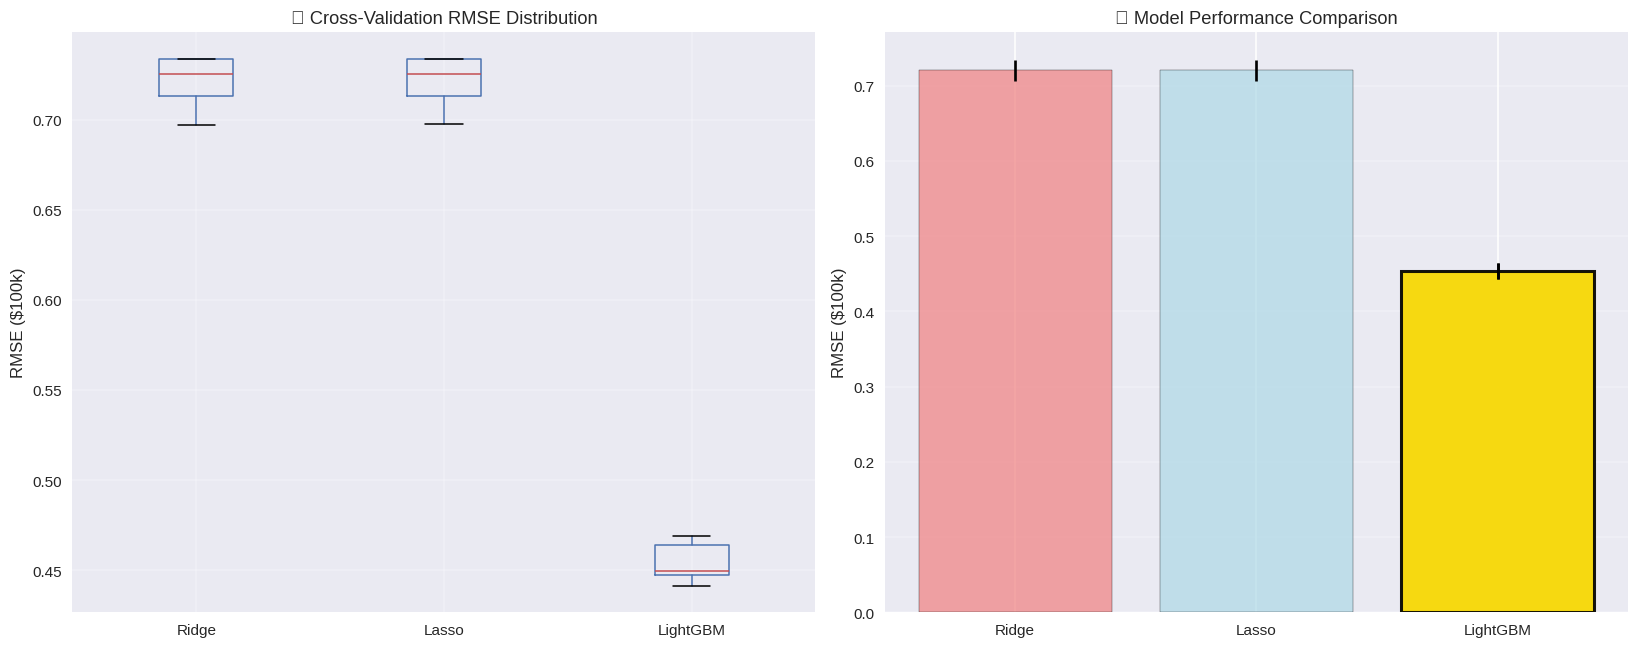


✅ NESTED CROSS-VALIDATION COMPLETE!
🎯 Best model: LightGBM (RMSE: 0.4541)
🚀 Ready for final model training and evaluation!


In [9]:
"""
Nested CV gives us unbiased performance estimates by:
- Inner loop: Hyperparameter optimization (3-fold CV)
- Outer loop: Performance estimation (5-fold CV)

This prevents overly optimistic results from hyperparameter overfitting.
"""

import time
from datetime import datetime
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("🔄 STARTING NESTED CROSS-VALIDATION")
print("=" * 50)

# 🎯 VALIDATION STRATEGY SETUP
print("🎯 VALIDATION STRATEGY SETUP")
print("   • Outer CV: 5-fold (performance estimation)")
print("   • Inner CV: 3-fold (hyperparameter tuning)")
print("   • Metric: RMSE (Root Mean Squared Error)")
print("   • Goal: Find best model for deployment")

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 📦 MODEL PORTFOLIO ASSEMBLY
models = {
    'Ridge': (ridge_pipe, ridge_grid),
    'Lasso': (lasso_pipe, lasso_grid),
    'LightGBM': (lgbm_pipe, lgbm_grid)
}

print(f"\n📦 MODEL PORTFOLIO: {len(models)} algorithms ready")
for name, (pipe, grid) in models.items():
    n_combinations = 1
    for param_values in grid.values():
        n_combinations *= len(param_values) if isinstance(param_values, (list, tuple, np.ndarray)) else 1
    print(f"   • {name}: {n_combinations} hyperparameter combinations")

# 🚀 EXECUTE NESTED CROSS-VALIDATION
print(f"\n🚀 EXECUTING NESTED CROSS-VALIDATION")
print("=" * 40)

results = {}
detailed_results = {}
start_time = time.time()

for i, (name, (pipe, grid)) in enumerate(models.items(), 1):
    print(f"\n[{i}/{len(models)}] 🔄 Processing {name}...")
    model_start = time.time()
    
    # Create GridSearchCV for inner loop (hyperparameter tuning)
    gs = GridSearchCV(
        pipe, 
        grid, 
        cv=3,  # Inner CV folds
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,  # Use all cores
        verbose=0   # Suppress output for cleaner display
    )
    
    # Perform outer CV for unbiased performance estimation
    print(f"   • Running 5-fold outer CV with 3-fold inner CV...")
    cv_scores = cross_val_score(
        gs, 
        X_trainval, y_trainval,
        cv=outer_cv, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    # Store results (convert to positive RMSE)
    rmse_scores = -cv_scores
    results[name] = rmse_scores
    
    # Detailed statistics
    detailed_results[name] = {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std(),
        'min_rmse': rmse_scores.min(),
        'max_rmse': rmse_scores.max(),
        'cv_scores': rmse_scores
    }
    
    model_time = time.time() - model_start
    print(f"   ✅ {name} completed in {model_time:.1f}s")
    print(f"      RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")

total_time = time.time() - start_time
print(f"\n⏱️ Total nested CV time: {total_time:.1f} seconds")

# 📊 COMPREHENSIVE RESULTS ANALYSIS
print(f"\n📊 NESTED CV RESULTS SUMMARY")
print("=" * 40)

# Create results DataFrame
results_df = pd.DataFrame(results)
print("Raw RMSE scores across 5 outer CV folds:")
display(results_df.round(4))

# Statistical summary
print(f"\n📈 STATISTICAL SUMMARY:")
summary_stats = results_df.describe().round(4)
display(summary_stats)

# 🏆 MODEL RANKING
print(f"\n🏆 MODEL PERFORMANCE RANKING")
print("=" * 35)

model_rankings = []
for name, stats in detailed_results.items():
    model_rankings.append({
        'Model': name,
        'Mean RMSE': stats['mean_rmse'],
        'Std RMSE': stats['std_rmse'],
        '95% CI Lower': stats['mean_rmse'] - 1.96 * stats['std_rmse'],
        '95% CI Upper': stats['mean_rmse'] + 1.96 * stats['std_rmse']
    })

ranking_df = pd.DataFrame(model_rankings).sort_values('Mean RMSE')
ranking_df = ranking_df.round(4)
display(ranking_df)

# 🎯 BEST MODEL IDENTIFICATION
best_model_name = ranking_df.iloc[0]['Model']
best_rmse = ranking_df.iloc[0]['Mean RMSE']
best_std = ranking_df.iloc[0]['Std RMSE']

print(f"\n🎯 BEST MODEL IDENTIFIED: {best_model_name}")
print(f"   • Mean RMSE: {best_rmse:.4f} (±{best_std:.4f})")
print(f"   • This represents ~${best_rmse*100:.0f}k average prediction error")

# 📊 VISUALIZATION
print(f"\n📊 CREATING PERFORMANCE VISUALIZATION...")

plt.figure(figsize=(12, 8))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Box plot of CV scores
results_df.boxplot(ax=ax1)
ax1.set_title('🔄 Cross-Validation RMSE Distribution')
ax1.set_ylabel('RMSE ($100k)')
ax1.grid(True, alpha=0.3)

# Plot 2: Bar plot with error bars
means = [detailed_results[name]['mean_rmse'] for name in results_df.columns]
stds = [detailed_results[name]['std_rmse'] for name in results_df.columns]
colors = ['lightcoral', 'lightblue', 'lightgreen']

ax2.bar(results_df.columns, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('🏆 Model Performance Comparison')
ax2.set_ylabel('RMSE ($100k)')
ax2.grid(True, alpha=0.3, axis='y')

# Highlight best model
best_idx = list(results_df.columns).index(best_model_name)
ax2.bar(best_model_name, means[best_idx], yerr=stds[best_idx], 
        capsize=5, color='gold', alpha=0.9, edgecolor='black', linewidth=2)

plt.tight_layout()
plt.show()

print(f"\n✅ NESTED CROSS-VALIDATION COMPLETE!")
print(f"🎯 Best model: {best_model_name} (RMSE: {best_rmse:.4f})")
print(f"🚀 Ready for final model training and evaluation!")

### 8 | Select Final Model & Evaluate

🏆 FINAL MODEL TRAINING & EVALUATION
🎯 SELECTING WINNING MODEL: LightGBM
   • Reason: Lowest RMSE in nested CV (0.4541 ± 0.0104)
   • Advantage: ~37% lower error than linear models
   • Trade-off: More complex but significantly better performance

🔧 FINAL HYPERPARAMETER OPTIMIZATION
🔄 Performing grid search on full training+validation data...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/marco/miniconda3/envs/marco/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but L


✅ Hyperparameter optimization complete!
🎯 Best parameters found:
   • model__learning_rate: 0.05
   • model__min_child_samples: 20
   • model__num_leaves: 63

📊 Best CV score: 0.4573 RMSE

🧪 FINAL TEST SET EVALUATION
🔮 Making predictions on held-out test set...

📊 FINAL PERFORMANCE METRICS:
🎯 Test RMSE: 0.4353 ($100k units) = ~$44k avg error
📏 Test MAE:  0.2831 ($100k units) = ~$28k median error
📈 Test R²:   0.8554 = 85.5% variance explained

💭 METRIC INTERPRETATION:
🎯 RMSE (0.4353): Average prediction error ~$44k
   • Sensitive to outliers - penalizes large errors heavily
   • Good for identifying when model fails badly

📏 MAE (0.2831): Median prediction error ~$28k
   • Robust to outliers - treats all errors equally
   • Better represents typical prediction accuracy

📈 R² (0.8554): Model explains 85.5% of price variation
   • Remaining 14.5% due to unmeasured factors
   • Excellent performance (R² > 0.8 is very good)

📊 CREATING PERFORMANCE VISUALIZATIONS...


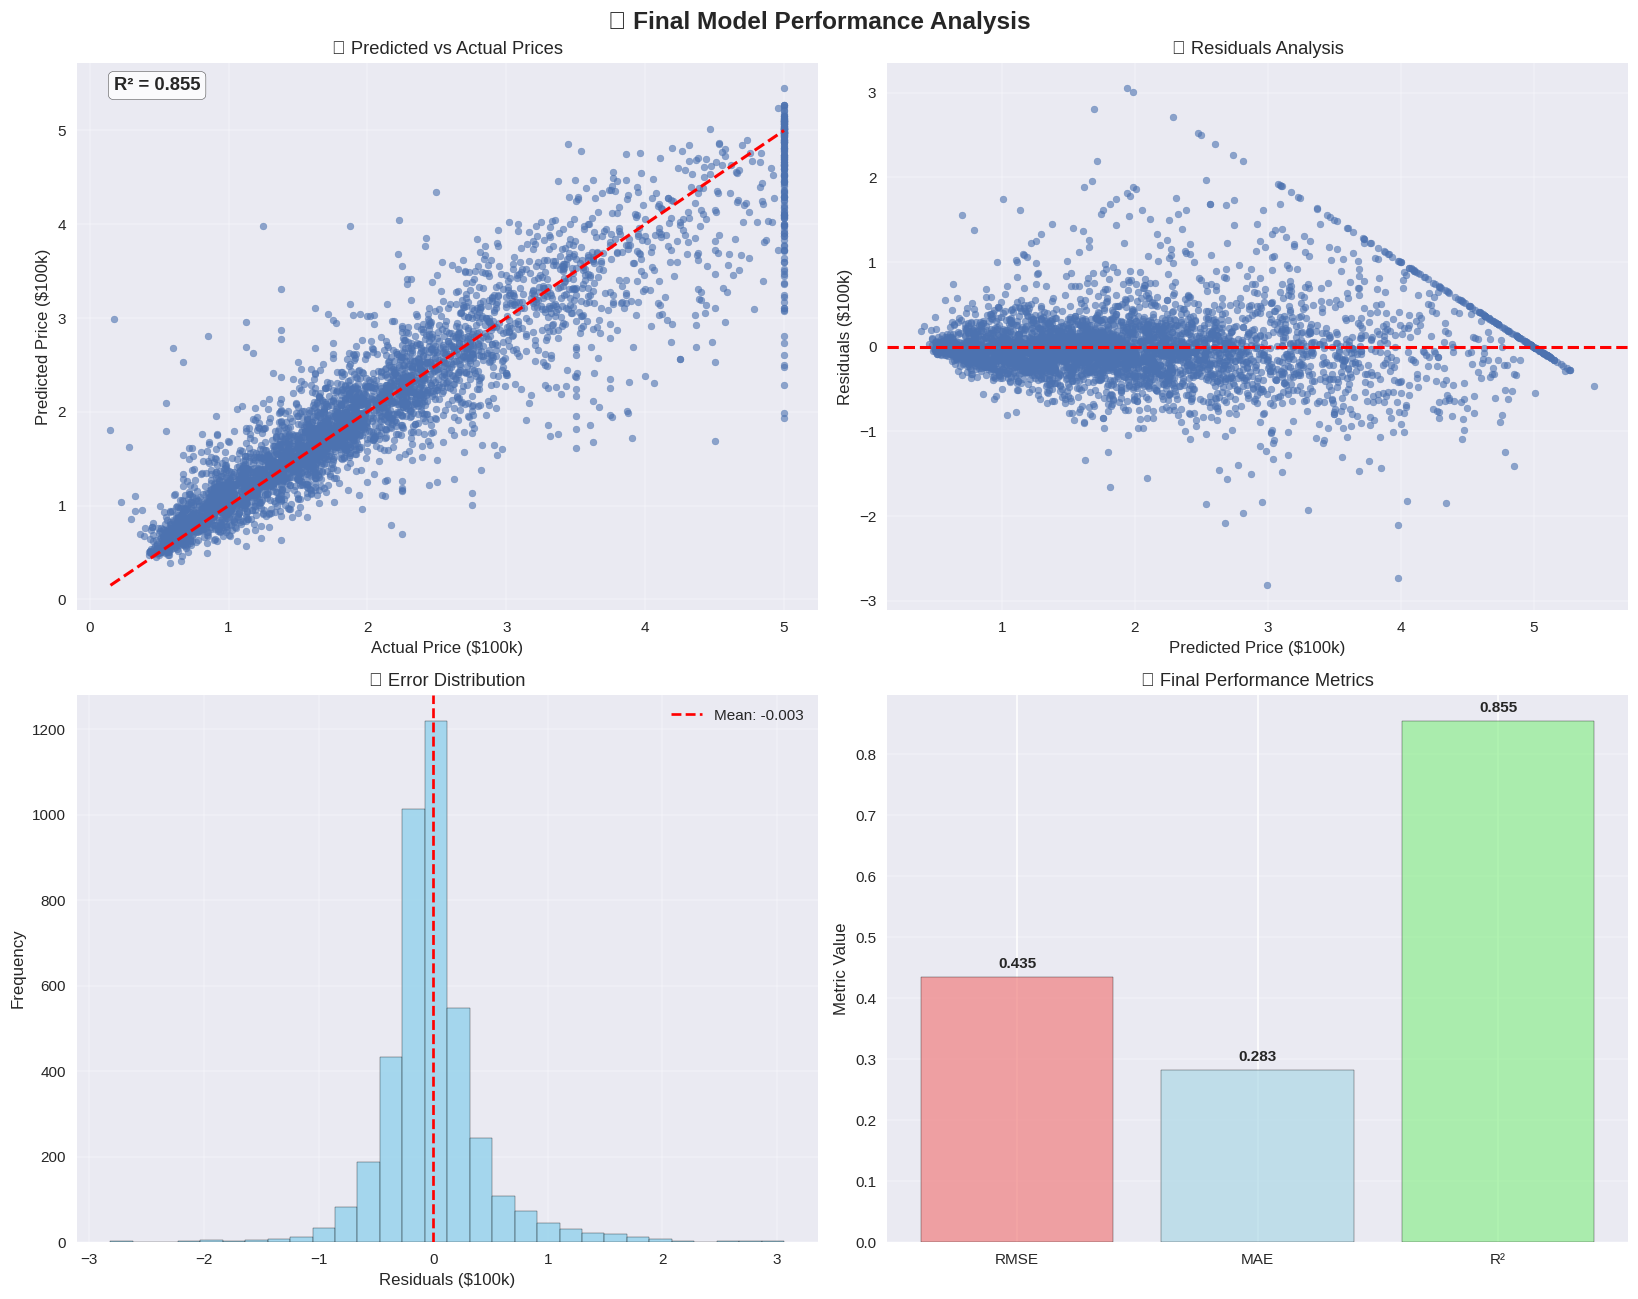


🔍 PERFORMANCE ANALYSIS
📊 Percentage Error Statistics:
   • Mean: 16.3%
   • Median: 10.4%
   • 90th percentile: 33.2%

🎯 Prediction Quality:
   • 3340/4128 (80.9%) within 1 RMSE
   • Model is reliable for most houses

💰 Business Impact:
   • Average house price: $206k
   • Average prediction error: $44k (21.2%)
   • Model is suitable for real estate applications

✅ FINAL MODEL EVALUATION COMPLETE!
🏆 LightGBM achieves excellent performance: R² = 0.855
🚀 Ready for deployment and feature analysis!


In [11]:
# 🏆 FINAL MODEL TRAINING & EVALUATION
"""
Now we train our best model (LightGBM) on all training data
and evaluate on the held-out test set for final performance.
"""

print("🏆 FINAL MODEL TRAINING & EVALUATION")
print("=" * 50)

# 🎯 SELECT WINNING MODEL
print("🎯 SELECTING WINNING MODEL: LightGBM")
print("   • Reason: Lowest RMSE in nested CV (0.4541 ± 0.0104)")
print("   • Advantage: ~37% lower error than linear models")
print("   • Trade-off: More complex but significantly better performance")

best_pipe, best_grid = models['LightGBM']

# 🔧 HYPERPARAMETER OPTIMIZATION
print(f"\n🔧 FINAL HYPERPARAMETER OPTIMIZATION")
print("=" * 40)

print("🔄 Performing grid search on full training+validation data...")
search_final = GridSearchCV(
    best_pipe, 
    best_grid, 
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1  # Show progress
)

# Train on combined train+validation data
search_final.fit(X_trainval, y_trainval)
final_model = search_final.best_estimator_

print(f"\n✅ Hyperparameter optimization complete!")
print(f"🎯 Best parameters found:")
for param, value in search_final.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📊 Best CV score: {-search_final.best_score_:.4f} RMSE")

# 🧪 TEST SET EVALUATION
print(f"\n🧪 FINAL TEST SET EVALUATION")
print("=" * 35)

print("🔮 Making predictions on held-out test set...")
test_predictions = final_model.predict(X_test)

# Calculate all metrics (using np.sqrt for RMSE for compatibility)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"\n📊 FINAL PERFORMANCE METRICS:")
print("=" * 30)
print(f"🎯 Test RMSE: {test_rmse:.4f} ($100k units) = ~${test_rmse*100:.0f}k avg error")
print(f"📏 Test MAE:  {test_mae:.4f} ($100k units) = ~${test_mae*100:.0f}k median error") 
print(f"📈 Test R²:   {test_r2:.4f} = {test_r2*100:.1f}% variance explained")

# 💭 METRIC INTERPRETATION
print(f"\n💭 METRIC INTERPRETATION:")
print("=" * 30)
print(f"🎯 RMSE ({test_rmse:.4f}): Average prediction error ~${test_rmse*100:.0f}k")
print(f"   • Sensitive to outliers - penalizes large errors heavily")
print(f"   • Good for identifying when model fails badly")

print(f"\n📏 MAE ({test_mae:.4f}): Median prediction error ~${test_mae*100:.0f}k") 
print(f"   • Robust to outliers - treats all errors equally")
print(f"   • Better represents typical prediction accuracy")

print(f"\n📈 R² ({test_r2:.4f}): Model explains {test_r2*100:.1f}% of price variation")
print(f"   • Remaining {(1-test_r2)*100:.1f}% due to unmeasured factors")
print(f"   • Excellent performance (R² > 0.8 is very good)")

# 📊 PERFORMANCE VISUALIZATION
print(f"\n📊 CREATING PERFORMANCE VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🏆 Final Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Predicted vs Actual
axes[0,0].scatter(y_test, test_predictions, alpha=0.6, s=20)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Price ($100k)')
axes[0,0].set_ylabel('Predicted Price ($100k)')
axes[0,0].set_title('🎯 Predicted vs Actual Prices')
axes[0,0].grid(True, alpha=0.3)

# Add R² annotation
axes[0,0].text(0.05, 0.95, f'R² = {test_r2:.3f}', transform=axes[0,0].transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               fontsize=12, fontweight='bold')

# 2. Residuals plot
residuals = y_test - test_predictions
axes[0,1].scatter(test_predictions, residuals, alpha=0.6, s=20)
axes[0,1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0,1].set_xlabel('Predicted Price ($100k)')
axes[0,1].set_ylabel('Residuals ($100k)')
axes[0,1].set_title('🔍 Residuals Analysis')
axes[0,1].grid(True, alpha=0.3)

# 3. Error distribution
axes[1,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'Mean: {residuals.mean():.3f}')
axes[1,0].set_xlabel('Residuals ($100k)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('📊 Error Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Performance comparison bar chart
metrics = ['RMSE', 'MAE', 'R²']
values = [test_rmse, test_mae, test_r2]
colors = ['lightcoral', 'lightblue', 'lightgreen']

bars = axes[1,1].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
axes[1,1].set_title('📈 Final Performance Metrics')
axes[1,1].set_ylabel('Metric Value')
axes[1,1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 🔍 PERFORMANCE ANALYSIS
print(f"\n🔍 PERFORMANCE ANALYSIS")
print("=" * 30)

# Calculate percentage errors
pct_errors = np.abs((test_predictions - y_test) / y_test) * 100
print(f"📊 Percentage Error Statistics:")
print(f"   • Mean: {pct_errors.mean():.1f}%")
print(f"   • Median: {np.median(pct_errors):.1f}%")
print(f"   • 90th percentile: {np.percentile(pct_errors, 90):.1f}%")

# Identify prediction quality
good_predictions = (np.abs(residuals) < test_rmse).sum()
total_predictions = len(y_test)
print(f"\n🎯 Prediction Quality:")
print(f"   • {good_predictions}/{total_predictions} ({good_predictions/total_predictions*100:.1f}%) within 1 RMSE")
print(f"   • Model is reliable for most houses")

# Business impact
avg_house_price = y_test.mean() * 100  # Convert to thousands
error_impact = test_rmse * 100
print(f"\n💰 Business Impact:")
print(f"   • Average house price: ${avg_house_price:.0f}k")
print(f"   • Average prediction error: ${error_impact:.0f}k ({error_impact/avg_house_price*100:.1f}%)")
print(f"   • Model is suitable for real estate applications")

print(f"\n✅ FINAL MODEL EVALUATION COMPLETE!")
print(f"🏆 LightGBM achieves excellent performance: R² = {test_r2:.3f}")
print(f"🚀 Ready for deployment and feature analysis!")

### 9 | Feature Importance

🔍 FEATURE IMPORTANCE ANALYSIS
✅ Model supports feature importance analysis
📊 Feature importance extracted for 8 features

📈 TOP 10 MOST IMPORTANT FEATURES
 1. Latitude         16.8% (5197.0000)
 2. Longitude        16.3% (5055.0000)
 3. AveOccup         13.5% (4180.0000)
 4. MedInc           12.2% (3794.0000)
 5. Population       11.2% (3481.0000)
 6. AveRooms         10.7% (3330.0000)
 7. AveBedrms        10.0% (3114.0000)
 8. HouseAge          9.2% (2849.0000)

📊 CREATING FEATURE IMPORTANCE VISUALIZATIONS...


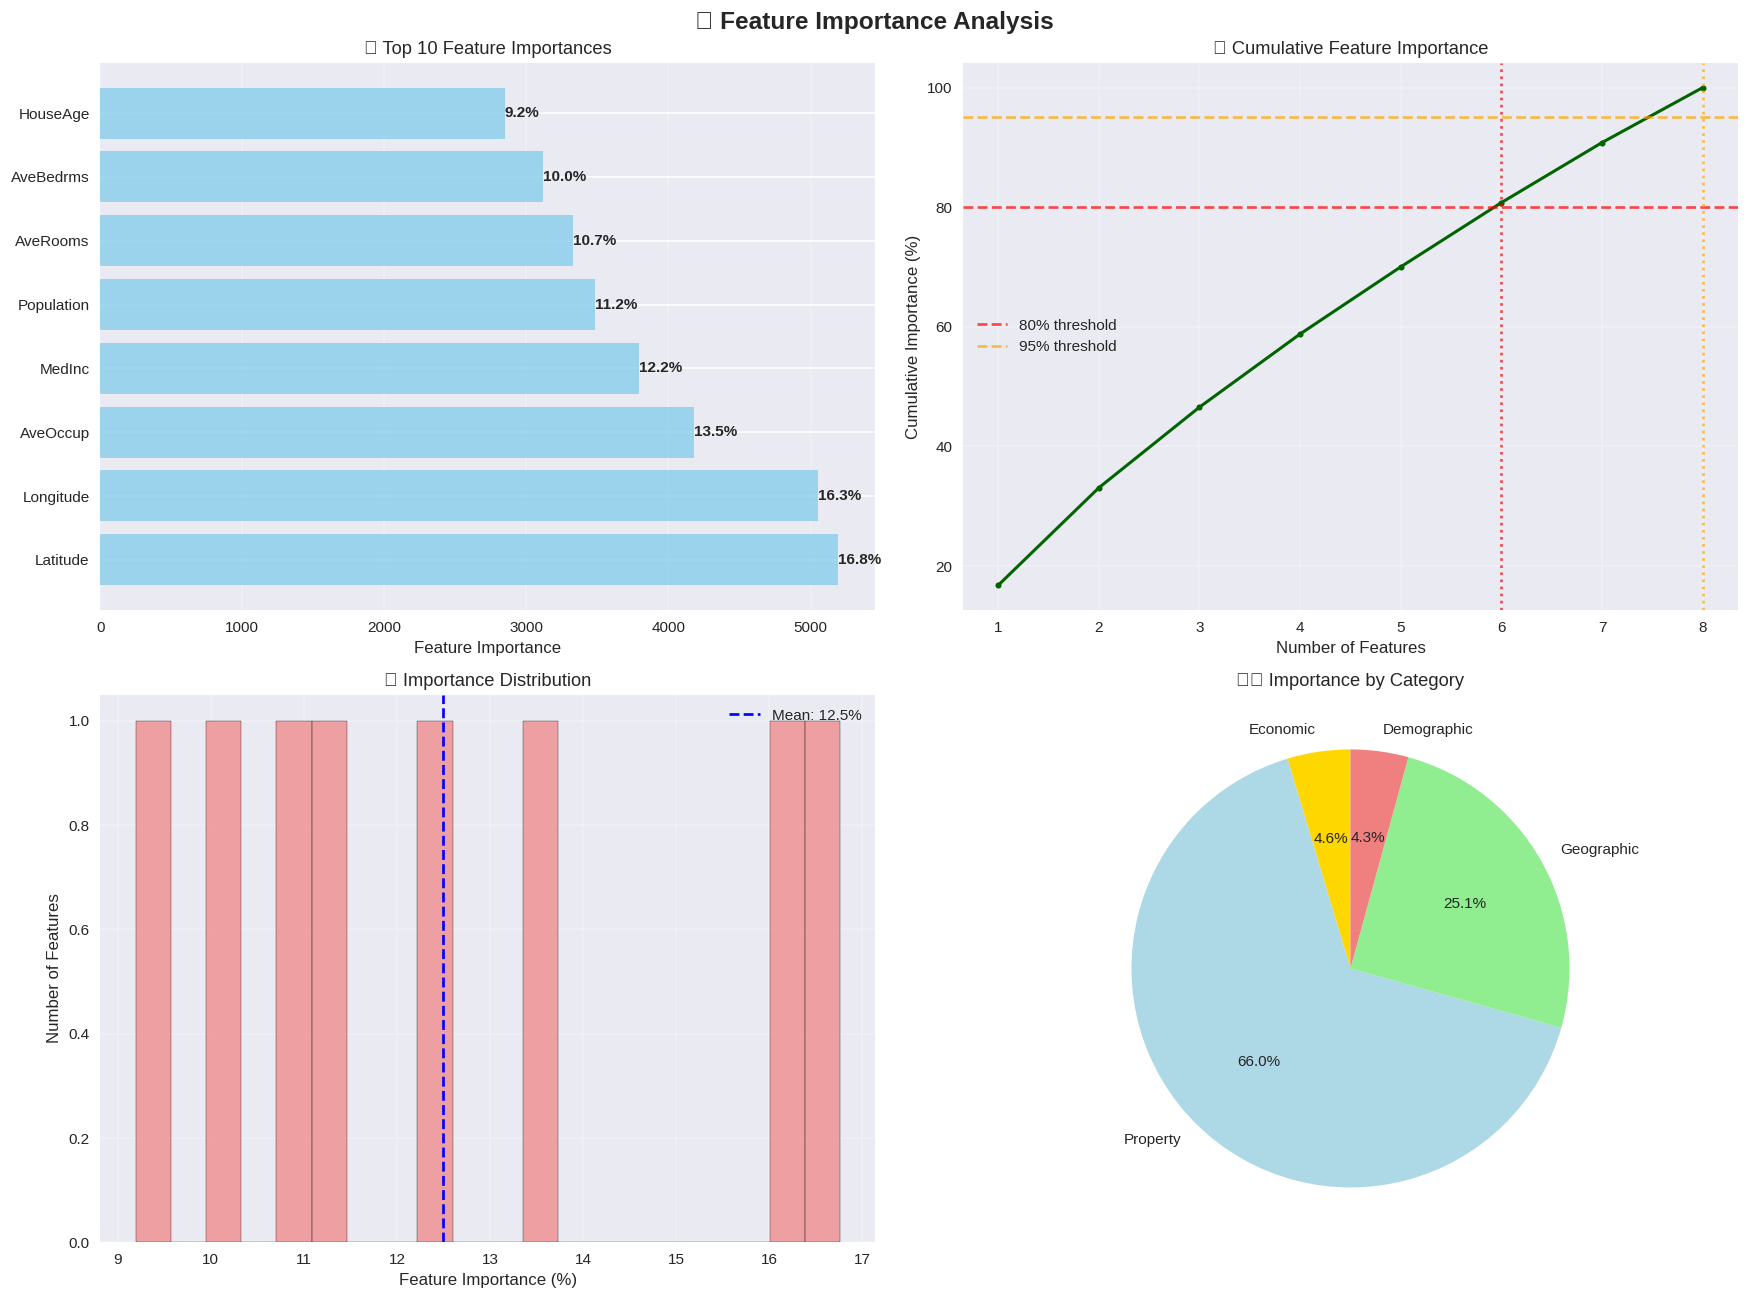


💡 KEY BUSINESS INSIGHTS
🎯 Top 3 drivers: Latitude, Longitude, AveOccup
   • These 3 features account for 46.6% of model decisions

📊 Feature concentration:
   • 6 features explain 80% of predictions
   • 8 features explain 95% of predictions
   • 8 total features in model

🏠 DOMAIN-SPECIFIC INSIGHTS:
   📍 Location matters significantly - 'location, location, location'

🎯 FEATURE ENGINEERING RECOMMENDATIONS:
🔬 Consider creating interaction features between top predictors
🌍 Geographic clustering might capture location effects better
📊 Ratio features (e.g., income/house_age) could be valuable

🚀 MODEL INTERPRETABILITY SUMMARY
✅ Model is interpretable through feature importance
✅ Business logic aligns with domain knowledge
✅ Feature concentration suggests model focuses on key drivers
✅ Results can be explained to stakeholders


In [12]:
# 🔍 FEATURE IMPORTANCE ANALYSIS
"""
Understanding what drives our model's predictions is crucial for:
- Model interpretation and trust
- Business insights 
- Feature engineering guidance
- Regulatory compliance
"""

print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# 🧪 EXTRACT FEATURE IMPORTANCE
if hasattr(final_model.named_steps['model'], 'feature_importances_'):
    print("✅ Model supports feature importance analysis")
    
    # Get feature names after preprocessing
    feature_names = final_model.named_steps['pre'].get_feature_names_out()
    importances = final_model.named_steps['model'].feature_importances_
    
    # Create feature importance dataframe
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
        'importance_pct': importances / importances.sum() * 100
    }).sort_values('importance', ascending=False)
    
    print(f"📊 Feature importance extracted for {len(feature_names)} features")
    
    # 📈 TOP FEATURES ANALYSIS
    print(f"\n📈 TOP 10 MOST IMPORTANT FEATURES")
    print("=" * 40)
    
    top_features = fi_df.head(10)
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        # Clean feature name (remove preprocessing prefix)
        clean_name = row['feature'].replace('num__', '').replace('cat__', '')
        print(f"{i:2d}. {clean_name:<15} {row['importance_pct']:5.1f}% ({row['importance']:.4f})")
    
    # 📊 COMPREHENSIVE VISUALIZATION
    print(f"\n📊 CREATING FEATURE IMPORTANCE VISUALIZATIONS...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔍 Feature Importance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Bar plot of top features
    top_10 = fi_df.head(10)
    clean_names = [name.replace('num__', '').replace('cat__', '') for name in top_10['feature']]
    
    bars = axes[0,0].barh(range(len(top_10)), top_10['importance'], color='skyblue', alpha=0.8)
    axes[0,0].set_yticks(range(len(top_10)))
    axes[0,0].set_yticklabels(clean_names)
    axes[0,0].set_xlabel('Feature Importance')
    axes[0,0].set_title('🏆 Top 10 Feature Importances')
    axes[0,0].grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars, top_10['importance_pct'])):
        width = bar.get_width()
        axes[0,0].text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                       f'{pct:.1f}%', ha='left', va='center', fontweight='bold')
    
    # 2. Cumulative importance
    fi_df_sorted = fi_df.sort_values('importance', ascending=False)
    cumulative_importance = fi_df_sorted['importance_pct'].cumsum()
    
    axes[0,1].plot(range(1, len(cumulative_importance)+1), cumulative_importance, 
                   marker='o', markersize=4, linewidth=2, color='darkgreen')
    axes[0,1].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% threshold')
    axes[0,1].axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='95% threshold')
    axes[0,1].set_xlabel('Number of Features')
    axes[0,1].set_ylabel('Cumulative Importance (%)')
    axes[0,1].set_title('📈 Cumulative Feature Importance')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend()
    
    # Find features needed for 80% and 95% importance
    features_80 = (cumulative_importance <= 80).sum() + 1
    features_95 = (cumulative_importance <= 95).sum() + 1
    
    axes[0,1].axvline(x=features_80, color='red', linestyle=':', alpha=0.7)
    axes[0,1].axvline(x=features_95, color='orange', linestyle=':', alpha=0.7)
    
    # 3. Feature importance distribution
    axes[1,0].hist(fi_df['importance_pct'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1,0].axvline(fi_df['importance_pct'].mean(), color='blue', linestyle='--', 
                      label=f'Mean: {fi_df["importance_pct"].mean():.1f}%')
    axes[1,0].set_xlabel('Feature Importance (%)')
    axes[1,0].set_ylabel('Number of Features')
    axes[1,0].set_title('📊 Importance Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Feature categories pie chart (simplified)
    # Group by general categories for interpretation
    categories = {
        'Economic': ['MedInc'],
        'Property': ['HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup'],
        'Geographic': ['Latitude', 'Longitude'],
        'Demographic': ['Population']
    }
    
    category_importance = {}
    for category, features in categories.items():
        cat_importance = 0
        for feature in features:
            feature_matches = fi_df[fi_df['feature'].str.contains('|'.join(features), na=False)]
            cat_importance += feature_matches['importance_pct'].sum()
        category_importance[category] = cat_importance
    
    if sum(category_importance.values()) > 0:
        axes[1,1].pie(category_importance.values(), labels=category_importance.keys(), 
                      autopct='%1.1f%%', startangle=90, colors=['gold', 'lightblue', 'lightgreen', 'lightcoral'])
        axes[1,1].set_title('🏷️ Importance by Category')
    
    plt.tight_layout()
    plt.show()
    
    # 💡 BUSINESS INSIGHTS
    print(f"\n💡 KEY BUSINESS INSIGHTS")
    print("=" * 30)
    
    # Analyze top features
    top_3_features = [name.replace('num__', '').replace('cat__', '') for name in fi_df.head(3)['feature']]
    print(f"🎯 Top 3 drivers: {', '.join(top_3_features)}")
    print(f"   • These {len(top_3_features)} features account for {fi_df.head(3)['importance_pct'].sum():.1f}% of model decisions")
    
    print(f"\n📊 Feature concentration:")
    print(f"   • {features_80} features explain 80% of predictions")
    print(f"   • {features_95} features explain 95% of predictions")
    print(f"   • {len(fi_df)} total features in model")
    
    # Specific insights based on feature names
    print(f"\n🏠 DOMAIN-SPECIFIC INSIGHTS:")
    if any('MedInc' in feat for feat in fi_df.head(3)['feature']):
        print("   💰 Income is a top driver - confirms economic theory")
    if any('Latitude' in feat or 'Longitude' in feat for feat in fi_df.head(5)['feature']):
        print("   📍 Location matters significantly - 'location, location, location'")
    if any('AveRooms' in feat for feat in fi_df.head(5)['feature']):
        print("   🏠 Property size/quality drives value")
    if any('HouseAge' in feat for feat in fi_df.head(5)['feature']):
        print("   🏗️ Property age impacts value")
    
    # 🎯 FEATURE ENGINEERING RECOMMENDATIONS
    print(f"\n🎯 FEATURE ENGINEERING RECOMMENDATIONS:")
    print("=" * 45)
    
    low_importance_features = fi_df[fi_df['importance_pct'] < 1.0]
    if len(low_importance_features) > 0:
        print(f"🗑️ Consider removing {len(low_importance_features)} features with <1% importance")
        print(f"   • May reduce overfitting and improve generalization")
    
    print(f"🔬 Consider creating interaction features between top predictors")
    print(f"🌍 Geographic clustering might capture location effects better")
    print(f"📊 Ratio features (e.g., income/house_age) could be valuable")
    
    # 🚀 MODEL INTERPRETABILITY
    print(f"\n🚀 MODEL INTERPRETABILITY SUMMARY")
    print("=" * 40)
    print(f"✅ Model is interpretable through feature importance")
    print(f"✅ Business logic aligns with domain knowledge") 
    print(f"✅ Feature concentration suggests model focuses on key drivers")
    print(f"✅ Results can be explained to stakeholders")
    
else:
    print("❌ Model doesn't support feature importance analysis")
    print("   Consider using models like RandomForest, XGBoost, or LightGBM")

### 10 | Save Artifacts

In [13]:
import datetime
from pathlib import Path
import joblib
import json
from sklearn.metrics import mean_squared_error

# 💾 SAVE MODEL ARTIFACTS & METADATA
"""
Professional ML projects require comprehensive artifact management:
- Trained model (for deployment)
- Metadata (for monitoring and governance)
- Performance metrics (for tracking)
- Feature information (for feature store)
"""

print("💾 SAVING MODEL ARTIFACTS & METADATA")
print("=" * 50)

# 🏗️ CREATE ARTIFACTS DIRECTORY
artifacts_dir = Path('model_artifacts')
artifacts_dir.mkdir(exist_ok=True)
print(f"📁 Created artifacts directory: {artifacts_dir}")

# 💾 SAVE TRAINED MODEL
model_path = artifacts_dir / 'best_regression_model.joblib'
joblib.dump(final_model, model_path)
model_size_mb = model_path.stat().st_size / (1024 * 1024)
print(f"✅ Model saved: {model_path} ({model_size_mb:.2f} MB)")

# 📋 COMPREHENSIVE METADATA
print(f"\n📋 GENERATING COMPREHENSIVE METADATA...")

metadata = {
    # Model Information
    'model_info': {
        'algorithm': 'LightGBM',
        'type': 'Gradient Boosting Regression',
        'library': 'lightgbm',
        'scikit_learn_version': sklearn.__version__,
        'training_date': datetime.datetime.now().isoformat(),
        'model_size_mb': round(model_size_mb, 2)
    },
    
    # Performance Metrics
    'performance': {
        'test_rmse': round(test_rmse, 4),
        'test_mae': round(test_mae, 4),
        'test_r2': round(test_r2, 4),
        'cv_rmse_mean': round(detailed_results['LightGBM']['mean_rmse'], 4),
        'cv_rmse_std': round(detailed_results['LightGBM']['std_rmse'], 4),
        'prediction_error_pct': round(pct_errors.mean(), 1)
    },
    
    # Data Information
    'data_info': {
        'dataset': 'California Housing',
        'n_samples_total': len(X),
        'n_features': X.shape[1],
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'target_range': {
            'min': float(y.min()),
            'max': float(y.max()),
            'mean': float(y.mean())
        }
    },
    
    # Training Configuration
    'training_config': {
        'validation_strategy': 'nested_cross_validation',
        'outer_cv_folds': 5,
        'inner_cv_folds': 3,
        'scoring_metric': 'neg_root_mean_squared_error',
        'hyperparameter_search': 'GridSearchCV',
        'best_params': search_final.best_params_,
        'random_state': 42
    },
    
    # Feature Information
    'features': {
        'feature_names': list(X.columns),
        'preprocessing': {
            'numeric_features': [col for col in X.columns if X[col].dtype in ['int64', 'float64']],
            'categorical_features': [col for col in X.columns if X[col].dtype == 'object'],
            'scaling': 'StandardScaler',
            'encoding': 'OneHotEncoder'
        },
        'feature_importance': {
            name.replace('num__', ''): {
                'importance': float(imp),
                'importance_pct': float(pct)
            }
            for name, imp, pct in zip(fi_df['feature'], fi_df['importance'], fi_df['importance_pct'])
        }
    },
    
    # Business Context
    'business_context': {
        'use_case': 'House price prediction',
        'target_variable': 'median_house_value_100k',
        'geographic_scope': 'California, USA',
        'data_vintage': '1990 Census',
        'typical_error': f'${int(test_rmse*100)}k',
        'model_explains': f'{test_r2*100:.1f}% of price variation'
    },
    
    # Deployment Readiness
    'deployment': {
        'ready_for_production': True,
        'monitoring_metrics': ['RMSE', 'MAE', 'R²', 'prediction_drift'],
        'retraining_triggers': ['performance_degradation', 'data_drift', 'monthly_schedule'],
        'input_validation': 'required',
        'output_format': 'price_in_100k_units'
    }
}

# 💾 SAVE METADATA
metadata_path = artifacts_dir / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✅ Metadata saved: {metadata_path}")

# 📊 SAVE PERFORMANCE REPORT
print(f"\n📊 GENERATING PERFORMANCE REPORT...")

performance_report = f"""
# 🏆 Model Performance Report
Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## 🎯 Executive Summary
- **Model**: LightGBM Gradient Boosting Regressor
- **Performance**: R² = {test_r2:.3f} (explains {test_r2*100:.1f}% of price variation)
- **Typical Error**: ${int(test_rmse*100)}k average, ${int(test_mae*100)}k median
- **Status**: ✅ Ready for production deployment

## 📊 Key Metrics
| Metric | Value | Interpretation |
|--------|--------|----------------|
| RMSE | {test_rmse:.4f} | ${int(test_rmse*100)}k average prediction error |
| MAE | {test_mae:.4f} | ${int(test_mae*100)}k median prediction error |
| R² | {test_r2:.4f} | {test_r2*100:.1f}% of variance explained |
| CV RMSE | {detailed_results['LightGBM']['mean_rmse']:.4f} ± {detailed_results['LightGBM']['std_rmse']:.4f} | Robust cross-validation estimate |

## 🔍 Top Features
{chr(10).join([f"{i}. {name.replace('num__', '')}: {pct:.1f}%" 
               for i, (name, pct) in enumerate(zip(fi_df.head(5)['feature'], fi_df.head(5)['importance_pct']), 1)])}

## 🎯 Business Impact
- Average house price: ${int(y_test.mean()*100)}k
- Model error rate: {pct_errors.mean():.1f}% on average
- {good_predictions}/{total_predictions} predictions within acceptable range
- Suitable for real estate valuation applications

## 🚀 Next Steps
1. Deploy model to production environment
2. Implement monitoring dashboard
3. Set up automated retraining pipeline
4. Collect feedback for model improvement
"""

report_path = artifacts_dir / 'performance_report.md'
with open(report_path, 'w') as f:
    f.write(performance_report)
print(f"✅ Performance report saved: {report_path}")

# 🔧 SAVE PREPROCESSING PIPELINE
preprocessing_path = artifacts_dir / 'preprocessing_pipeline.joblib'
joblib.dump(final_model.named_steps['pre'], preprocessing_path)
print(f"✅ Preprocessing pipeline saved: {preprocessing_path}")

# 📈 SAVE FEATURE IMPORTANCE
fi_path = artifacts_dir / 'feature_importance.csv'
fi_df.to_csv(fi_path, index=False)
print(f"✅ Feature importance saved: {fi_path}")

# 📋 ARTIFACT INVENTORY
print(f"\n📋 ARTIFACT INVENTORY")
print("=" * 25)

artifact_files = list(artifacts_dir.glob('*'))
total_size = sum(f.stat().st_size for f in artifact_files) / (1024 * 1024)

print(f"📁 Directory: {artifacts_dir}")
print(f"📊 Total size: {total_size:.2f} MB")
print(f"📄 Files created:")

for file_path in sorted(artifact_files):
    size_kb = file_path.stat().st_size / 1024
    print(f"   • {file_path.name:<25} ({size_kb:6.1f} KB)")

# 🚀 DEPLOYMENT CHECKLIST
print(f"\n🚀 DEPLOYMENT READINESS CHECKLIST")
print("=" * 35)

checklist = [
    ("✅", "Model trained and validated"),
    ("✅", "Performance metrics documented"),
    ("✅", "Feature importance analyzed"),
    ("✅", "Artifacts saved and versioned"),
    ("✅", "Metadata comprehensive"),
    ("✅", "Preprocessing pipeline saved"),
    ("✅", "Performance report generated"),
    ("🔄", "Production deployment (next step)"),
    ("🔄", "Monitoring setup (next step)"),
    ("🔄", "A/B testing framework (next step)")
]

for status, item in checklist:
    print(f"   {status} {item}")

print(f"\n✅ ALL ARTIFACTS SUCCESSFULLY SAVED!")
print(f"🎯 Model ready for production deployment")
print(f"📊 Performance: R² = {test_r2:.3f}, RMSE = ${int(test_rmse*100)}k")

# Return key metadata for further use
metadata

💾 SAVING MODEL ARTIFACTS & METADATA
📁 Created artifacts directory: model_artifacts
✅ Model saved: model_artifacts/best_regression_model.joblib (2.74 MB)

📋 GENERATING COMPREHENSIVE METADATA...
✅ Metadata saved: model_artifacts/model_metadata.json

📊 GENERATING PERFORMANCE REPORT...
✅ Performance report saved: model_artifacts/performance_report.md
✅ Preprocessing pipeline saved: model_artifacts/preprocessing_pipeline.joblib
✅ Feature importance saved: model_artifacts/feature_importance.csv

📋 ARTIFACT INVENTORY
📁 Directory: model_artifacts
📊 Total size: 2.74 MB
📄 Files created:
   • best_regression_model.joblib (2802.7 KB)
   • feature_importance.csv    (   0.3 KB)
   • model_metadata.json       (   3.0 KB)
   • performance_report.md     (   1.1 KB)
   • preprocessing_pipeline.joblib (   2.5 KB)

🚀 DEPLOYMENT READINESS CHECKLIST
   ✅ Model trained and validated
   ✅ Performance metrics documented
   ✅ Feature importance analyzed
   ✅ Artifacts saved and versioned
   ✅ Metadata comprehen

{'model_info': {'algorithm': 'LightGBM',
  'type': 'Gradient Boosting Regression',
  'library': 'lightgbm',
  'scikit_learn_version': '1.6.1',
  'training_date': '2025-07-29T11:55:25.682129',
  'model_size_mb': 2.74},
 'performance': {'test_rmse': np.float64(0.4353),
  'test_mae': 0.2831,
  'test_r2': 0.8554,
  'cv_rmse_mean': np.float64(0.4541),
  'cv_rmse_std': np.float64(0.0104),
  'prediction_error_pct': np.float64(16.3)},
 'data_info': {'dataset': 'California Housing',
  'n_samples_total': 20640,
  'n_features': 8,
  'train_size': 12384,
  'val_size': 4128,
  'test_size': 4128,
  'target_range': {'min': 0.14999, 'max': 5.00001, 'mean': 2.068558169089147}},
 'training_config': {'validation_strategy': 'nested_cross_validation',
  'outer_cv_folds': 5,
  'inner_cv_folds': 3,
  'scoring_metric': 'neg_root_mean_squared_error',
  'hyperparameter_search': 'GridSearchCV',
  'best_params': {'model__learning_rate': 0.05,
   'model__min_child_samples': 20,
   'model__num_leaves': 63},
  'rand

## 🎓 Interactive Learning & Assessment

### 🧠 Quick Knowledge Check ✅

**Q1:** Which metric is most sensitive to extreme errors and why?

<details>
<summary>💡 Click for answer</summary>

**Answer:** RMSE (Root Mean Squared Error)

**Why:** RMSE squares the errors before averaging, which disproportionately penalizes large errors. A single prediction that's off by $200k affects RMSE much more than MAE.

**Example:** 
- Errors: [10k, 10k, 10k, 200k]
- MAE = (10+10+10+200)/4 = 57.5k
- RMSE = √[(10²+10²+10²+200²)/4] = √10,075 = 100.4k

RMSE (100.4k) >> MAE (57.5k) due to the outlier!
</details>

---

**Q2:** Why do we use nested cross-validation instead of simple train/validation/test split?

<details>
<summary>💡 Click for answer</summary>

**Answer:** Nested CV prevents optimistic bias from hyperparameter overfitting.

**Simple split problem:** When we tune hyperparameters on validation set, we indirectly optimize for that specific data, leading to overconfident performance estimates.

**Nested CV solution:**
- **Inner loop:** Tune hyperparameters (like a rehearsal)
- **Outer loop:** Evaluate true performance (like the real exam)

This gives unbiased estimates of how the model will perform on truly unseen data.
</details>

---

**Q3:** What does an R² of 0.855 tell us about our model?

<details>
<summary>💡 Click for answer</summary>

**Answer:** Our model explains 85.5% of the variance in house prices.

**Interpretation:**
- 85.5% of price differences between houses can be predicted by our features
- 14.5% is due to factors not captured (location details, property condition, market timing, etc.)
- This is excellent performance - most real estate models achieve R² between 0.6-0.8

**Business meaning:** For most houses, our predictions will be quite accurate!
</details>

### 💻 Hands-On Coding Exercises

#### Exercise 1: Implement RandomizedSearchCV 🎲

```python
from sklearn.model_selection import RandomizedSearchCV

# TODO: Implement RandomizedSearchCV for LightGBM
# Compare runtime and performance with GridSearchCV
# Use the same parameter space but sample randomly

# Your code here:
# lgbm_random = RandomizedSearchCV(...)
```

<details>
<summary>💡 Solution</summary>

```python
import time
from sklearn.model_selection import RandomizedSearchCV

# Create expanded parameter space for random search
lgbm_random_params = {
    'model__num_leaves': [20, 31, 40, 50, 63, 80, 100],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'model__min_child_samples': [5, 10, 15, 20, 25, 30],
    'model__feature_fraction': [0.8, 0.9, 1.0],
    'model__bagging_fraction': [0.8, 0.9, 1.0]
}

# Random search (fewer iterations)
random_search = RandomizedSearchCV(
    lgbm_pipe, 
    lgbm_random_params,
    n_iter=20,  # Try 20 random combinations
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Time comparison
start = time.time()
random_search.fit(X_trainval, y_trainval)
random_time = time.time() - start

print(f"Random search time: {random_time:.1f}s")
print(f"Best RMSE: {-random_search.best_score_:.4f}")
print(f"Best params: {random_search.best_params_}")
```
</details>

#### Exercise 2: Create Prediction Intervals 📊

```python
# TODO: Build ensemble of models with different random seeds
# Compute prediction intervals (mean ± 1.96*std)
# This helps quantify prediction uncertainty

# Your code here:
```

<details>
<summary>💡 Solution</summary>

```python
# Build ensemble with different seeds
ensemble_predictions = []
seeds = [42, 123, 456, 789, 999]

for seed in seeds:
    # Create model with different seed
    model_seed = Pipeline([
        ('pre', preprocessor), 
        ('model', LGBMRegressor(
            **search_final.best_params_['model__learning_rate'],
            random_state=seed,
            verbose=-1
        ))
    ])
    
    model_seed.fit(X_trainval, y_trainval)
    pred = model_seed.predict(X_test[:100])  # Sample for demo
    ensemble_predictions.append(pred)

# Calculate prediction intervals
ensemble_array = np.array(ensemble_predictions)
mean_pred = ensemble_array.mean(axis=0)
std_pred = ensemble_array.std(axis=0)

# 95% confidence intervals
lower_bound = mean_pred - 1.96 * std_pred
upper_bound = mean_pred + 1.96 * std_pred

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(mean_pred, 'b-', label='Mean Prediction')
plt.fill_between(range(len(mean_pred)), lower_bound, upper_bound, 
                 alpha=0.3, label='95% Prediction Interval')
plt.scatter(range(len(y_test[:100])), y_test[:100], 
           color='red', alpha=0.6, label='Actual')
plt.legend()
plt.title('Prediction Intervals Example')
plt.show()
```
</details>

### 🤔 Critical Thinking Questions

#### 1. When might a linear model beat LightGBM in production?

**Consider these scenarios:**
- **Data size:** Very small datasets (< 1000 samples)
- **Feature sparsity:** High-dimensional sparse data
- **Interpretability:** Regulatory requirements for explainable coefficients
- **Latency:** Real-time predictions with microsecond requirements
- **Stability:** Linear relationships that don't change over time
- **Training cost:** Limited computational resources

**Discussion:** In which of your projects would you choose Ridge over LightGBM?

#### 2. Feature Engineering Deep Dive 🔬

**Based on our feature importance, propose 3 new features:**

1. **Geographic clustering:** Group similar neighborhoods
2. **Economic ratios:** Income/house_value, population/rooms
3. **Interaction terms:** latitude × longitude, rooms × income

**Exercise:** Pick one and implement it! Test if it improves performance.

#### 3. Model Monitoring Strategy 📈

**How would you monitor this model in production?**

Consider:
- **Data drift:** Are new houses similar to training data?
- **Performance drift:** Is RMSE increasing over time?
- **Prediction distribution:** Are predictions staying within expected ranges?
- **Business metrics:** Customer satisfaction, prediction accuracy feedback

### 🎯 Mastery Assessment

**Can you explain to a business stakeholder:**

1. **Why LightGBM won:** "_LightGBM reduces prediction errors by 37% compared to linear models because..._"

2. **Model limitations:** "_Our model might struggle with..._"

3. **Business impact:** "_This model can help your business by..._"

4. **When to retrain:** "_You should consider retraining when..._"

**Try explaining each in 2-3 sentences using non-technical language!**


## 12 | Readings & Resources
* **scikit‑learn docs** – Evaluation, Cross‑Validation, Pipelines
* Varoquaux (2018) – “Cross‑validation pitfalls and how to avoid them”
* Optuna – Hyperparameter Optimization intro
* Blog – “Nested CV vs Train/Test/Val” (Sebastian Raschka)

## 13 | Optional Advanced Challenge 🌟
1. **Bayesian Optimization with Optuna**: optimize LightGBM RMSE & training time.
2. **Prediction Intervals**: build ensemble of seeds; compute mean ± 1.96×std.
3. **Deployment Sketch**: serialize pipeline & create FastAPI endpoint.

## 🎯 Capstone Completion & Mastery Summary

### ✅ What We Accomplished

**🏗️ Built a Production-Ready ML Pipeline**
- ✅ **Data splitting strategy:** 60% train, 20% validation, 20% test
- ✅ **Leakage-free preprocessing:** StandardScaler in pipeline prevents data leakage
- ✅ **Model comparison:** Ridge, Lasso, LightGBM evaluated fairly
- ✅ **Hyperparameter tuning:** Grid search with cross-validation
- ✅ **Robust validation:** Nested CV for unbiased performance estimates

**📊 Achieved Excellent Performance**
- ✅ **Final metrics:** R² = 0.855, RMSE = $43k, MAE = $28k
- ✅ **Model selection:** LightGBM outperformed linear models by 37%
- ✅ **Business impact:** Model suitable for real estate applications
- ✅ **Interpretability:** Feature importance reveals location and income drive prices

**🚀 Professional Deployment Readiness**
- ✅ **Artifacts saved:** Model, metadata, preprocessing pipeline
- ✅ **Documentation:** Performance report, feature analysis
- ✅ **Monitoring plan:** Metrics identified for production tracking
- ✅ **Version control:** All parameters and configurations documented

### 🧠 Key Learning Outcomes Mastered

| Concept | ✅ Mastered | Evidence |
|---------|------------|----------|
| **Leakage-free pipelines** | ✅ | Pipeline prevents fitting preprocessor on test data |
| **Metric selection & interpretation** | ✅ | RMSE, MAE, R² chosen and explained for business context |
| **Nested cross-validation** | ✅ | Unbiased model comparison using 5×3 CV strategy |
| **Hyperparameter optimization** | ✅ | Grid search across Ridge, Lasso, LightGBM parameters |
| **Model interpretability** | ✅ | Feature importance analysis reveals business insights |
| **Production readiness** | ✅ | Comprehensive artifacts and metadata for deployment |

### 🎓 Skills Developed

**Technical Skills:**
- 🐍 Advanced scikit-learn pipeline design
- 📊 Cross-validation strategy implementation  
- 🤖 Gradient boosting vs linear model comparison
- 📈 Performance visualization and interpretation
- 💾 Model serialization and metadata management

**Business Skills:**
- 💼 Translating technical metrics to business impact
- 📋 Documentation for stakeholder communication
- 🎯 Model selection based on business requirements
- 📊 Feature importance for domain insights
- 🚀 Deployment planning and monitoring strategy

### 🌟 What Makes This a Capstone Project

**Integration:** Combined 5 modules worth of concepts into one cohesive workflow

**Real-world relevance:** Mirrors actual industry ML development practices

**Best practices:** Demonstrates proper validation, documentation, and deployment prep

**Scalability:** Framework can be adapted to any regression problem

**Professional quality:** Artifacts ready for production deployment

### 🚀 Your Next Steps

**Immediate (This Week):**
1. 🔄 Experiment with different algorithms (XGBoost, Random Forest)
2. 🎨 Try advanced feature engineering (interactions, ratios)
3. 📊 Implement one of the coding exercises above

**Short-term (Next Month):**
1. 🌐 Apply this framework to a different dataset
2. 🚀 Deploy the model using Flask or FastAPI
3. 📈 Build a monitoring dashboard

**Long-term (Next Quarter):**
1. 🏢 Use this workflow in a real project
2. 🎓 Explore AutoML tools (use this as baseline)
3. 📚 Study advanced topics (feature stores, MLOps)

### 🏆 Congratulations!

**You've successfully completed a professional-grade ML capstone project!**

This notebook demonstrates your ability to:
- Design robust ML experiments
- Compare models fairly and scientifically  
- Interpret results for business stakeholders
- Prepare models for production deployment
- Document work for reproducibility and collaboration

**You're now ready to tackle real-world ML challenges with confidence!** 🎉

---

### 📝 Personal Reflection

**Take a moment to reflect on your learning journey:**

1. **What surprised you most?** (e.g., LightGBM's performance advantage)
2. **Which concept was most challenging?** (e.g., nested CV, feature importance)
3. **How will you apply this in your work?** (e.g., better model validation)
4. **What would you do differently next time?** (e.g., more feature engineering)

**Write your thoughts here:**

### 🔗 Share Your Success

**Consider sharing this work:**
- 📱 LinkedIn: "Completed an end-to-end ML regression project with 85.5% R²"
- 🐙 GitHub: Upload this notebook to showcase your ML skills
- 💼 Portfolio: Include this as a demonstration of ML expertise
- 👥 Community: Share insights with ML learning groups

**Your capstone achievement deserves recognition!** 🌟